In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

(720, 960, 3)


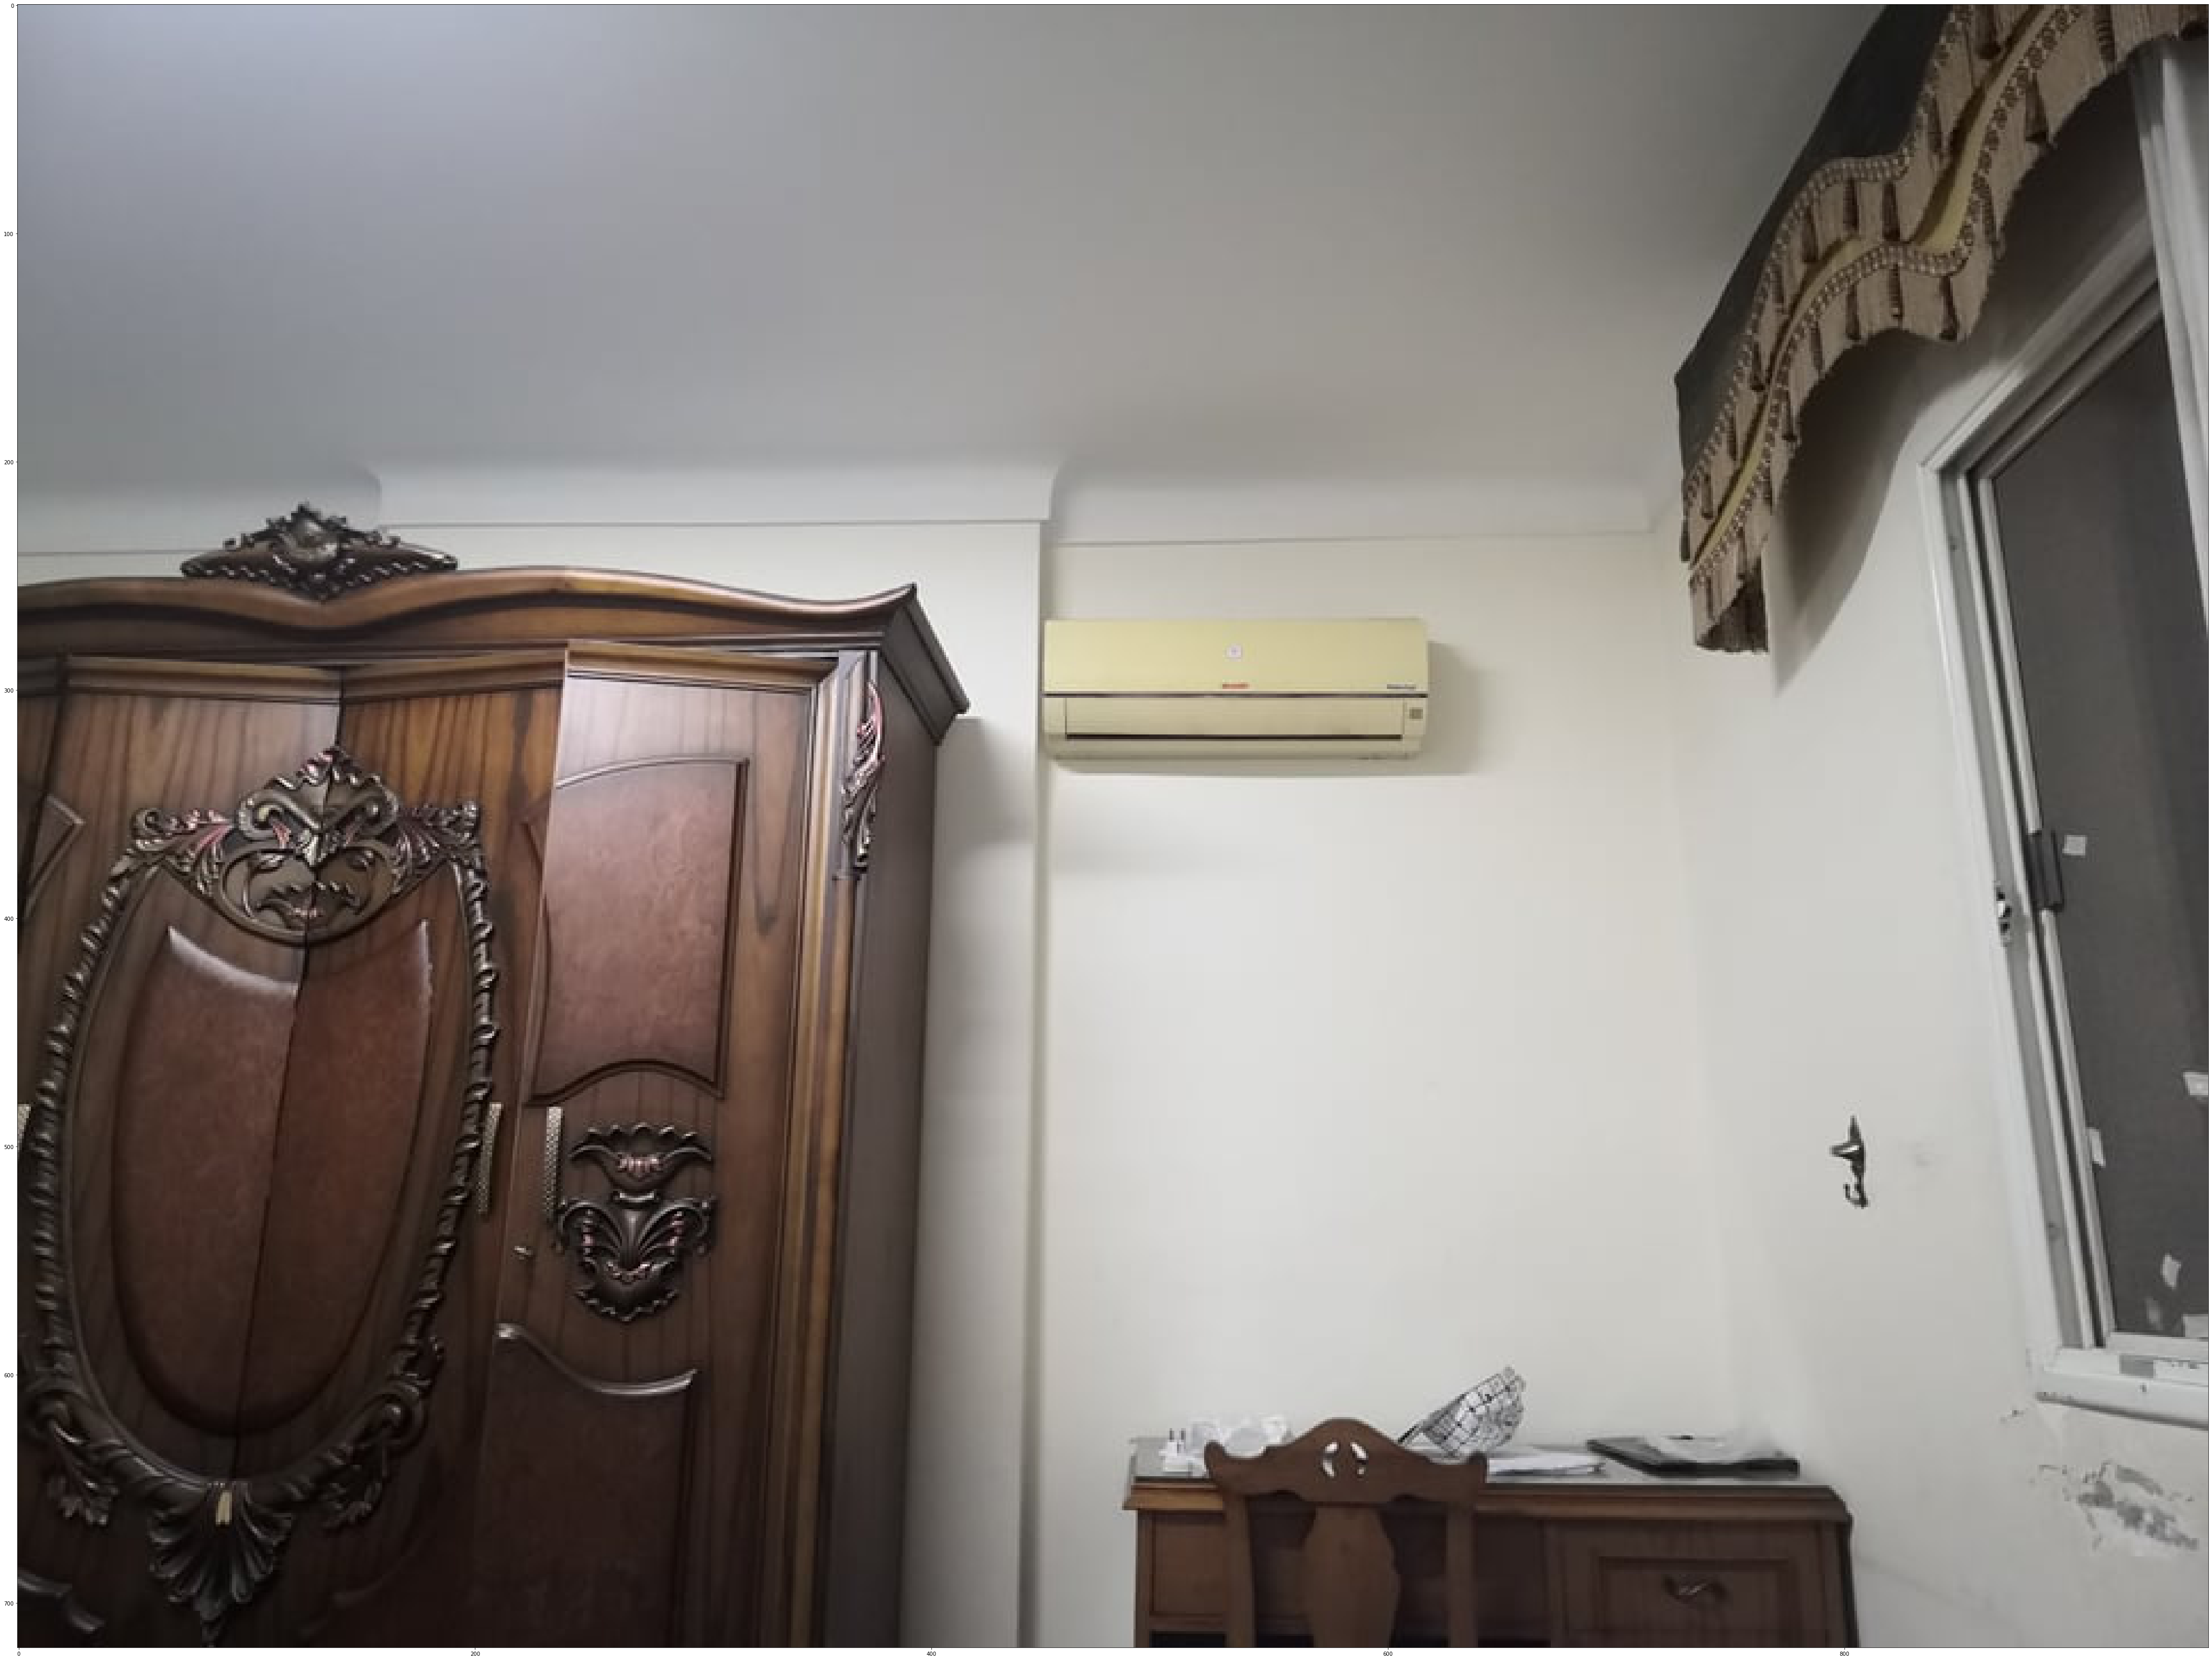

In [5]:
def show(img, size=75):
    plt.figure(figsize = (size,size))
    
    if len(img.shape) == 2: # if grayscale, set cmap
        plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    else: # if 3 channels, change from BGR to RGB
        plt.imshow(img[...,::-1])
        
    plt.show()

img = cv2.imread("./image_mosaics_1.jpg")
show(img)

## Finding The KeyPoints Using SIFT

In [79]:
def get_keypoints(img):
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img,None)
    img_keypoints=cv2.drawKeypoints(img,kp,img)
#     show(img_keypoints, 8)
    return kp, des

## Finding Correspondence

In [88]:
# Return correspondences in the following format:
# [
#  pos in imgA, pos in imgB
#  [(x,y), (x,y)], # match 1
#  [(x,y), (x,y)] # match 2
#  ...
# ]

def get_correspondences(imgA, imgB):
    kp1, des1 = get_keypoints(imgA)
    kp2, des2 = get_keypoints(imgB)

    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    
    # des1 = queryDescriptor, des2 = trainDescriptor
    matches = bf.knnMatch(des1,des2,k=2)
    
    # Apply ratio test
    good = []
    final_matches = []
    for m,n in matches:
        if m.distance < 0.235*n.distance:
            good.append([m])
            final_matches.append([kp1[m.queryIdx].pt, kp2[m.trainIdx].pt])
            
            
    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(imgA,kp1,imgB,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    show(img3)
    print(f"found {len(good)} matches")
    
    return final_matches

## Construct Homography Matrix

In [89]:
def construct_homography_matrix(matches):
    A = [];
    
    for match in matches:
        xi = match[0][0]
        yi = match[0][1]
        
        xj = match[1][0]
        yj = match[1][1]
        
        A.append([xi, yi, 1, 0, 0, 0, -1*xj*xi, -1*xj*yi, -1*xj])
        A.append([0, 0, 0, xi, yi, 1, -1*yj*xi, -1*yj*yi, -1*yj])
        
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    h = vh[-1]
    return np.array(h).reshape((3,3))

print(construct_homography_matrix([
    [(1,2), (3,4)],
    [(5,6), (7,8)],
    [(9,10), (11,12)],
    [(13,14), (15,16)],
]))

[[ 0.0341357   0.03374931  0.10202071]
 [-0.58071259  0.6485976  -0.44494256]
 [-0.11981445  0.11981445 -0.05192943]]


(720, 1920, 3)


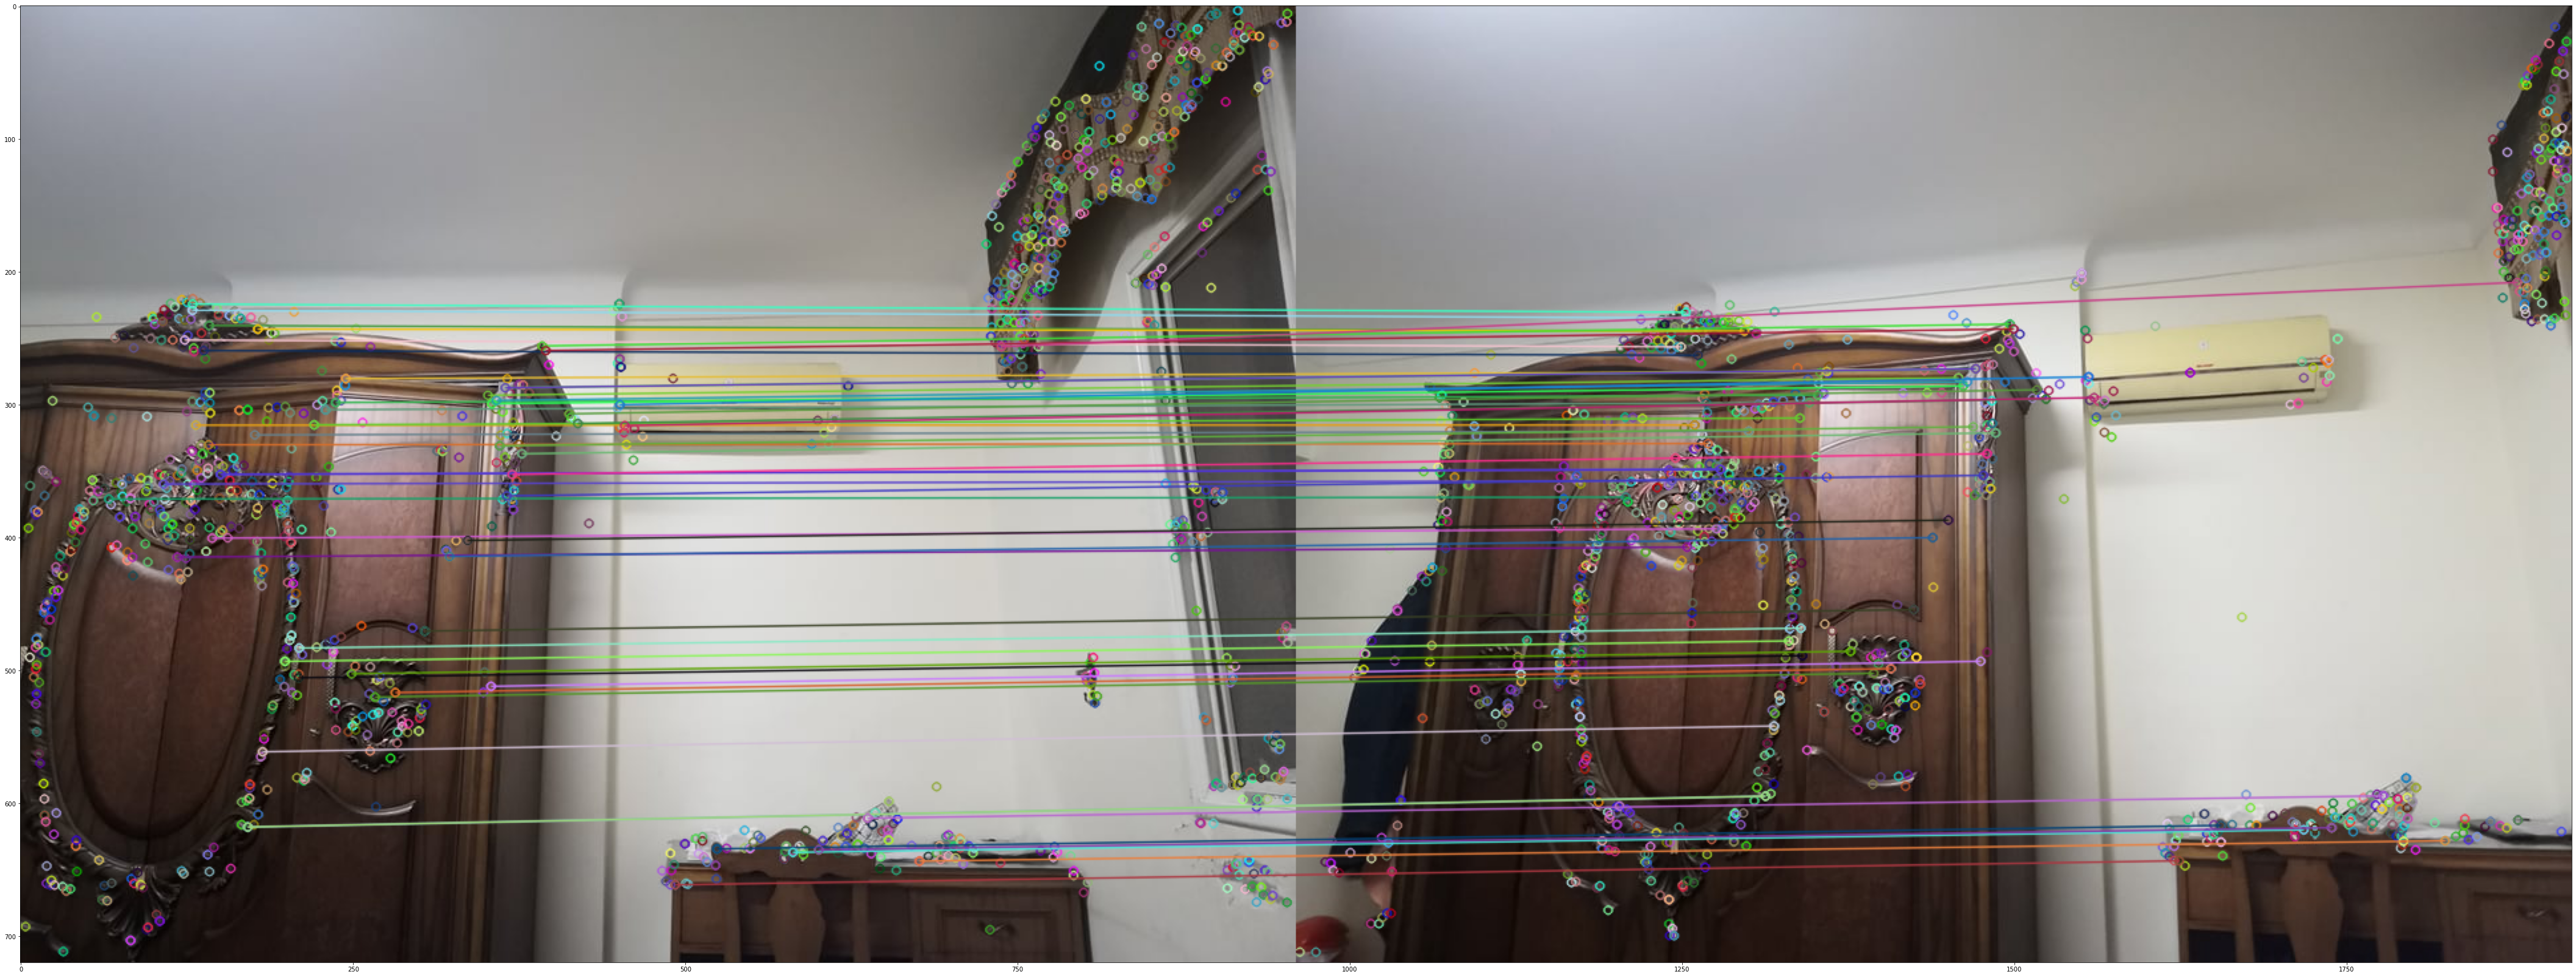

found 54 matches


In [97]:
imgA = cv2.imread("./image_mosaics_1.jpg")
imgB = cv2.imread("./image_mosaics_2.jpg")


correspondences = get_correspondences(imgA, imgB)
H = construct_homography_matrix(correspondences)

### Test Homography Matrix

(107.5010757446289, 359.5982666015625)
[[107.50107574]
 [359.5982666 ]
 [  1.        ]]
[[107.50107574]
 [359.5982666 ]
 [  1.        ]]
[[282.6792455 ]
 [357.33231448]
 [  1.        ]]
(282.2554626464844, 357.1645202636719)
(720, 960, 3)


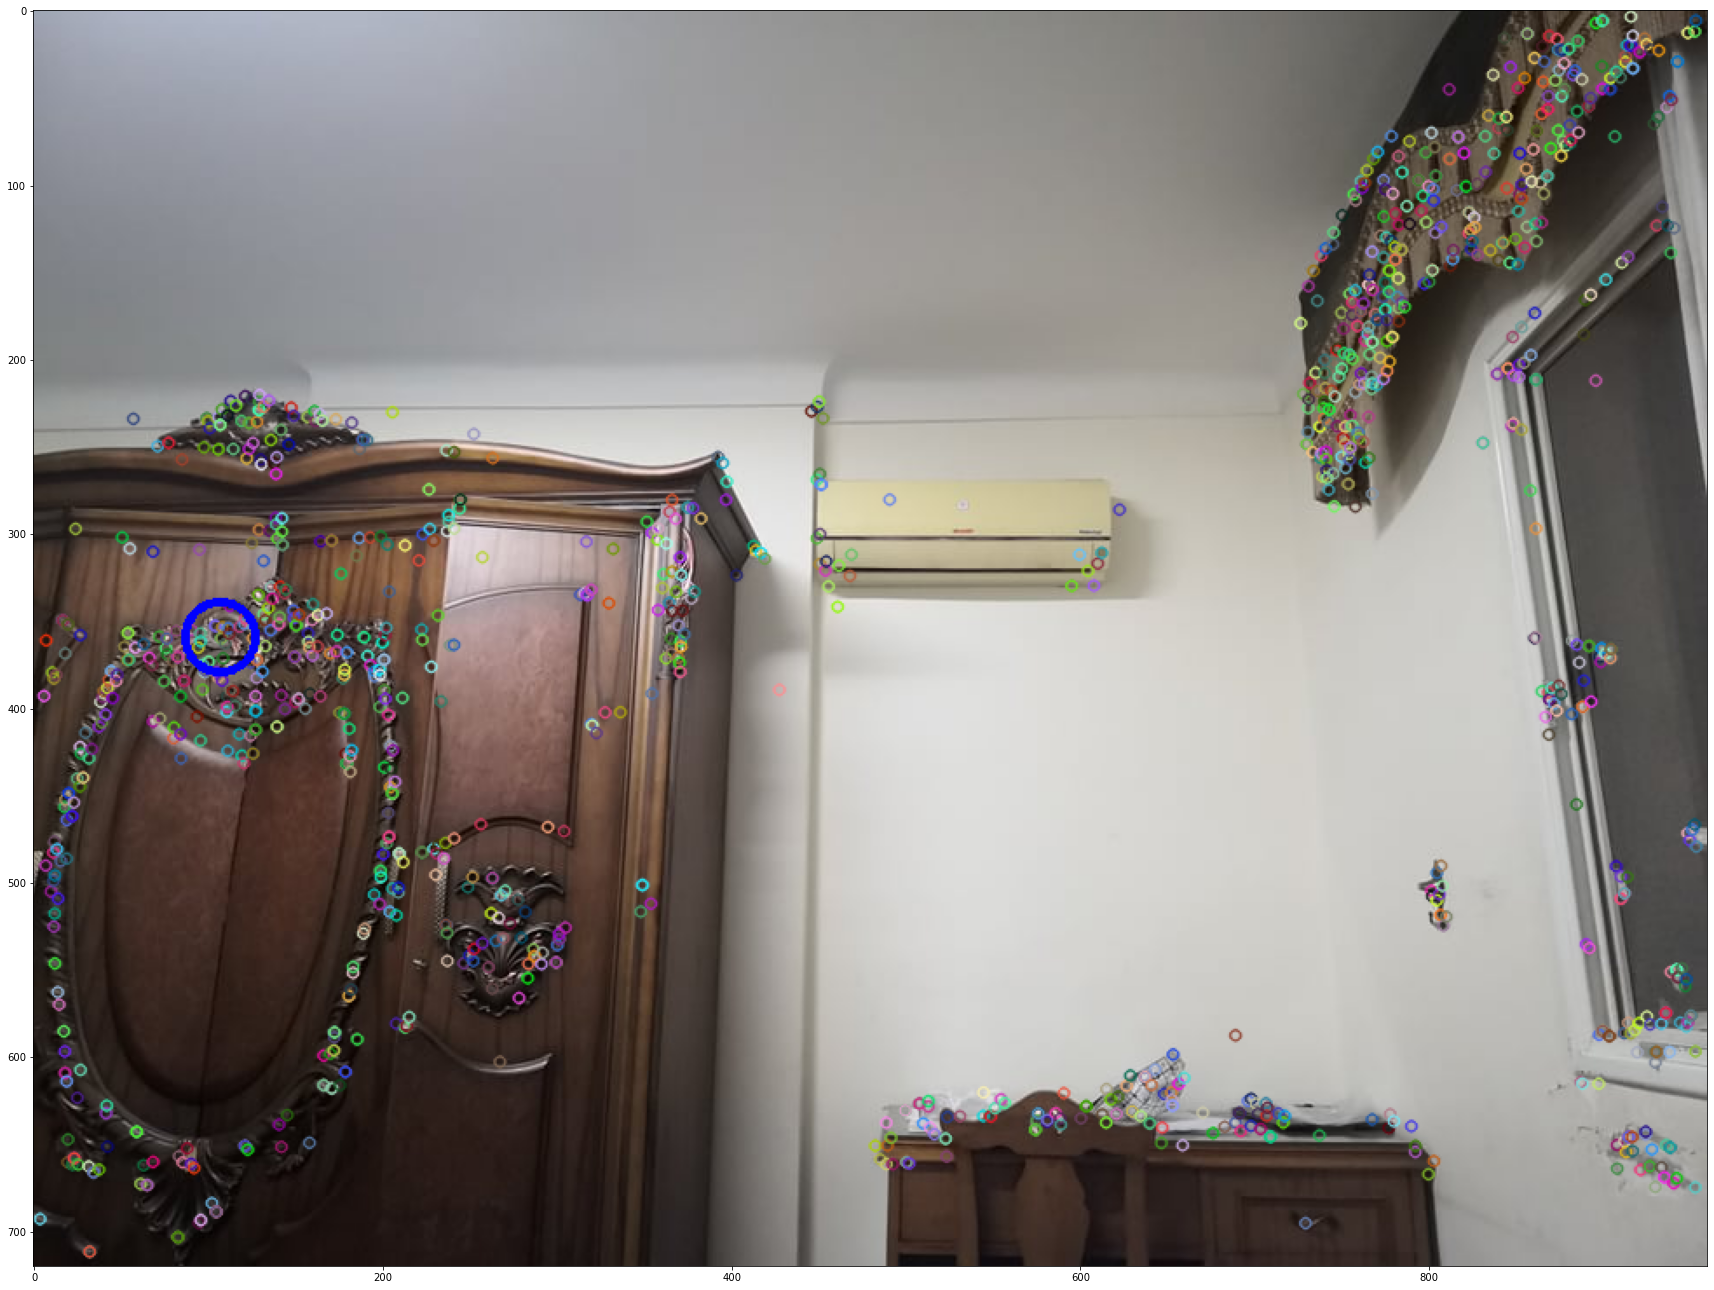

(720, 960, 3)


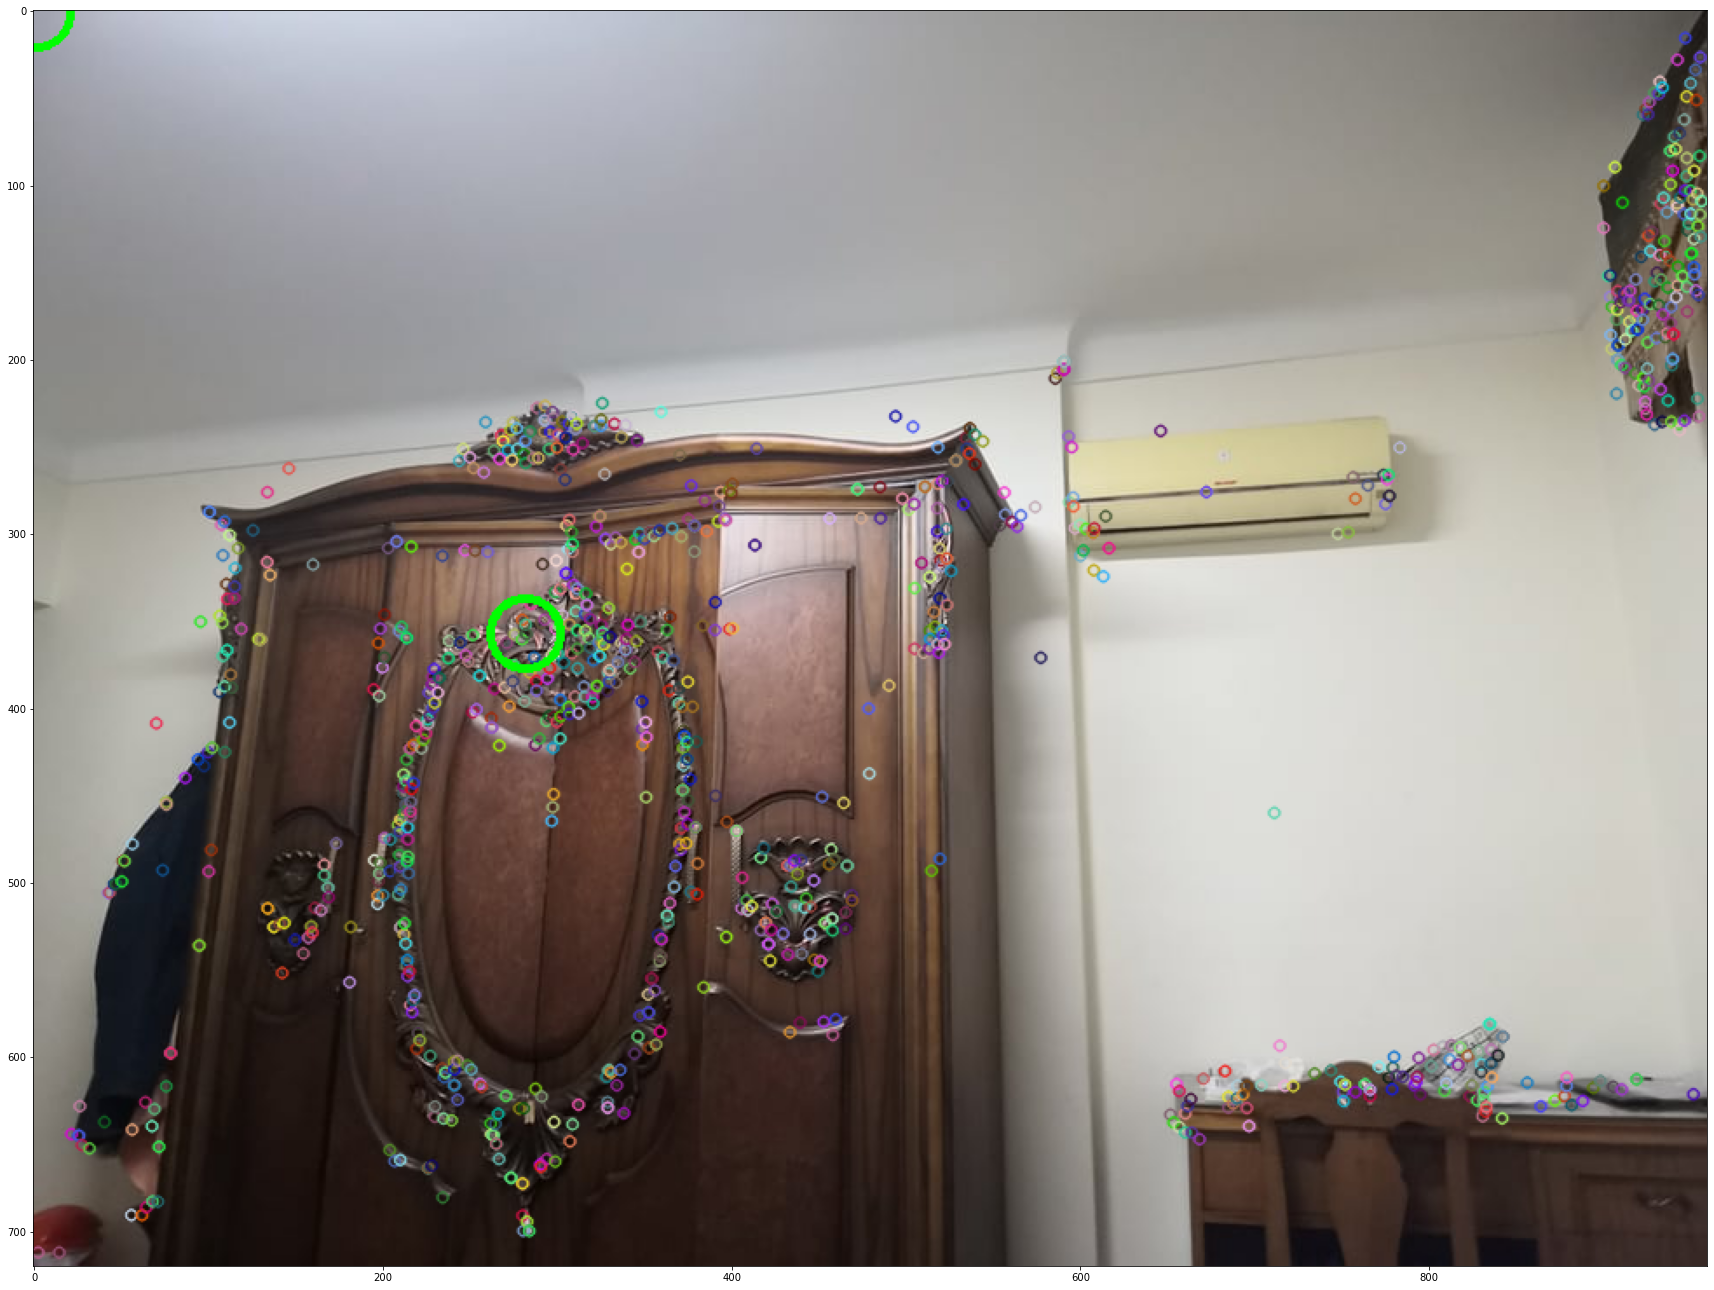

In [96]:
imgA = cv2.imread("./image_mosaics_1.jpg")
imgB = cv2.imread("./image_mosaics_2.jpg")

pointA = correspondences[1][0]
pointB = correspondences[1][1]


pointAHomogenousCoord = np.array([pointA[0], pointA[1], 1]).reshape((3,1))

print(pointA)
print(pointAHomogenousCoord)

pointA_ = np.matmul(H, pointAHomogenousCoord)
pointA_ /= pointA_[2][0]

print(pointAHomogenousCoord)
print(pointA_)
print(pointB)

imgA = cv2.circle(imgA, (int(pointA[0]), int(pointA[1])), 20, (255,0,0), 4)
show(imgA)

imgB = cv2.circle(imgB, (int(pointB[0]), int(pointB[1])), 20, (255,0,0), 4)
show(imgB)

imgB = cv2.circle(imgB, (int(pointA_[0][0]), int(pointA_[1][0])), 20, (0,255,0), 4)

show(imgA, 30)
show(imgB, 30)